In [7]:
# PPO Algorithm: An improvement on TRPO Algorithm

import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import copy
from tqdm import tqdm

In [8]:
# PolicyNet and ValueNet

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim = 1)
    
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [9]:
# Advantage function based on baseline subtraction

def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
        
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [10]:
# PPO-Clip

class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, epsilon, lmbda, epochs
                ,device):
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic = ValueNet(state_dim, hidden_dim)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        
        self.gamma = gamma
        self.epsilon = epsilon # Epsilon for clipping
        self.lmbda = lmbda
        self.epochs = epochs
        self.device = device
        
    def take_action(self, state):
        state = torch.tensor([state], dtype = torch.float).to(device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample() # Sample action based on policy distribution
        
        return action.item()
    
    
    def update(self, transition_dict):
        state = torch.tensor(transition_dict['state'], dtype = torch.float).to(device)
        action = torch.tensor(transition_dict['action']).view(-1, 1).to(device)
        reward = torch.tensor(transition_dict['reward'], dtype = torch.float).view(-1, 1).to(device)
        next_state = torch.tensor(transition_dict['next_state'], dtype = torch.float).to(device)
        done = torch.tensor(transition_dict['done'], dtype = torch.float).view(-1, 1).to(device)
        
        td_target = reward + self.gamma * self.critic(next_state) * (1 - done)
        
        td_delta = td_target - self.critic(state)
        
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta).to(self.device)
        
        old_log_probs = torch.log(self.actor(state).gather(1, action)).detach()
        
        for _ in range(epochs):
            log_probs = torch.log(self.actor(state).gather(1, action))
            
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantage
            
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(state), td_target.detach()))
            
            # Update Actor
            
            
            self.actor_optimizer.zero_grad()

            actor_loss.backward()
            
            self.actor_optimizer.step()
            
            # Update Critic
            
            self.critic_optimizer.zero_grad()

            critic_loss.backward()
            
            self.critic_optimizer.step()

In [11]:
# On-policy Training

def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'state': [], 'action': [], 'next_state': [], 'reward': [], 'done': []}
                state, _ = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)[:4]
                    transition_dict['state'].append(state)
                    transition_dict['action'].append(action)
                    transition_dict['next_state'].append(next_state)
                    transition_dict['reward'].append(reward)
                    transition_dict['done'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

In [12]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 300
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 5
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, eps, lmbda,
            epochs, device)

return_list = train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 30/30 [03:08<00:00,  6.27s/it, episode=300, return=89598.100]


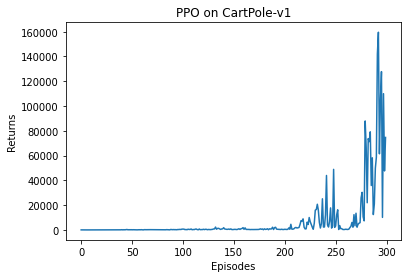

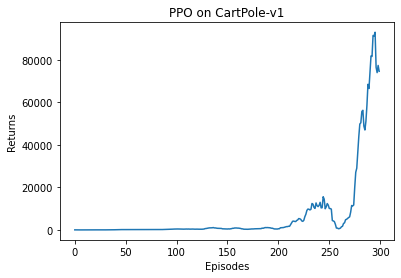

In [13]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()